## AI Agent Bhorali

### An AI Agent that given a token address returns a full analysis report for the token with details on

Score the token from 1 to 10 for the following parameters with detailed reports
supporting each score:
    1. Very Short term investment potential (1-7 Days)
    2. Short term investment potential (1-2 months)
    3. Medium term investment potential (3-6 months)
    4. Long term investment potential (6-36 months)
    5. Value investment potential (3-10 years or maybe more)

In [2]:
from typing import Annotated, List, Optional
from typing_extensions import TypedDict
from IPython.display import Image
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()


# langgraph
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import ToolMessage, HumanMessage, AIMessage, SystemMessage
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import Command, interrupt
from langchain_core.tools import tool, InjectedToolCallId
from langgraph.prebuilt.chat_agent_executor import AgentState
import requests
from pydantic import BaseModel, Field

# web3
from web3 import Web3
from solana.rpc.async_api import AsyncClient
import asyncio
import base64

In [71]:
# # class TokenSchema(BaseModel):
# #     """Details of the token"""
# #     name: str = Field(description="Name of the token")
# #     address: str = Field(description="Address of the token")
# #     chain: str = Field(description="Chain of the token")
# #     price: float = Field(description="Price of the token")
# #     market_cap: float = Field(description="Market cap of the token")
# #     volume: float = Field(description="Volume 24h) of the token")
# #     liquidity: float = Field(description="Liquidity of the token")

# #     # fill the below only after the token is assessed
# #     news: List[str] = Field(description="List of news related to the token")
# #     # team_verification: Optional[str] = Field(description="If team is verified, return team details, otherwise return None")
# #     # red_flags: Optional[List[str]] = Field(description="List of red flags for the token if any, otherwise return None")

# #     # to be filled by agent
# #     rank: int = Field(description="An investment ranking for the token. 1 meaning very risky and bad investment. 10 meaning safe and high potential for profits")
# #     risk_analysis: str = Field(description="Risk Analysis report of the token")

# # class TokenSchemas(BaseModel):
# #     coins: List[TokenSchema]


# class AgentState(TypedDict):
#     task: str 
#     coins_to_invest: TokenSchemas
#     coins_risk_assessed: TokenSchemas
    

# ## TODO: Add some other sources instead of dexscreener.
# ## e.g coingecko, coinmarketcap etc.
# ## and mostly evm compatible chains.
# def get_top_dexscreener_coins():
#     '''Get the top 30 tokens on dexscreener'''
#     chain_id = "solana"

#     # Get the tokens with most active boosts on dexscreener (rate-limit 60 requests per minute)
#     response = requests.get(
#         "https://api.dexscreener.com/token-boosts/top/v1",
#         headers={},
#     )
        
#     data = response.json()

#     # Extract token addresses from the response data
#     token_addresses = [item["tokenAddress"] for item in data if item["chainId"] == chain_id]

#     response = requests.get(
#         f"https://api.dexscreener.com/tokens/v1/{chain_id}/{','.join(token_addresses)}",
#         headers={},
#     )

#     data = response.json()
    
#     # return Command(
#     #     update = {
#     #         "messages": [
#     #             ToolMessage(f'Successfully fetched top 30 tokens on dexscreener, {data}', tool_call_id=tool_call_id)
#     #         ]
#     #     }
#     # )
#     # for testing lets just use top 5 for now
#     return f'Top tokens on dexscreener: {data[:5]}'


# coins_prompt = """You are an expert DEX Trading Analysis AI specializing in identifying short-term cryptocurrency opportunities. Analyze DEXScreener data and filter out the high-potential tokens (maximum 2) by examining price action, volume, liquidity, and holder patterns. 
# For each recommendation, provide: token details (address, chain, price), key metrics (market cap, volume, liquidity)."""


# risk_assessment_prompt = """You are an expert risk analyst for DEX Trading. Your task is to analyze the provided news and information for each token to assess its risk level and investment potential.

# For each token, analyze the provided news to evaluate:

# 1. News & Information Analysis:
#    - Overall sentiment in news coverage
#    - Major developments or announcements
#    - Community reception and social signals
#    - Team activities and communications
#    - Any reported incidents or concerns

# 2. Risk Indicators:
#    - Potential scam patterns or red flags
#    - Team transparency and credibility
#    - Similar tokens or copycat warnings
#    - Security concerns or vulnerabilities
#    - Regulatory compliance issues

# Based on your news analysis:
# 1. Assign a rank from 1 to 10 where:
#    - 1-3: High risk (serious red flags, likely scam, or major concerns)
#    - 4-6: Moderate risk (some concerns, requires careful monitoring)
#    - 7-8: Lower risk (minor concerns but generally positive outlook)
#    - 9-10: Lowest risk (strong positive indicators, minimal concerns)

# 2. Write a concise risk analysis report including:
#    - Summary of key news findings
#    - Identified risk factors
#    - Investment potential based on news sentiment
#    - Any specific warnings or recommendations

# Format your response according to the TokenSchemas structure, updating only the 'rank' and 'risk_analysis' fields for each token."""



In [4]:
class AgentState(TypedDict):
    token: str # address of the token

    price_pattern_analysis: str # output of the price pattern analysis by one node
    token_distribution_analysis: str # output of the token distribution analysis by one node
    whales_analysis: str # output of the whales analysis by one node
    volume_pattern_analysis: str # output of the volume pattern analysis by one node
    token_news_analysis: str # output of the token news analysis by one node

    final_report: str # final report of the token analysis by master node

chain = "Ethereum"

prompt_end = f"""Analyze the price pattern data provided to you below
                for a token on {chain} and provide a detailed report detailing your critique of the investment 
                potential in the token. Your report will be forwarded to another investment expert node which
                will create a final report after analysing the data from you and from other similar nodes. So make
                sure to structure your report best for analysis by your successive agent. Also add any data if you 
                think it is relevant (and not redundant) for analysis by your successive agent."""


PRICE_PATTERN_ANALYSIS_PROMPT = f"""You are an expert Price Pattern Analyst. {prompt_end}"""

TOKEN_DISTRIBUTION_ANALYSIS_PROMPT = f"""You are an expert crypto Investment Analyst for token distribution data. {prompt_end}"""

WHALES_ANALYSIS_PROMPT = f"""You are an expert crypto investment analyst for whale addresses data. {prompt_end}"""

VOLUME_PATTERN_ANALYSIS_PROMPT = f"""You are an expert crypto investment Analyst for volume pattern data. {prompt_end}"""

TOKEN_NEWS_ANALYSIS_PROMPT = f"""You are an expert crypto investment analyst given the news for the token. {prompt_end}"""

FINAL_REPORT_PROMPT = """You are an expert crypto investment analyst. Analyse all the reports given to you for the token and create a final report  
                        scoring the token from 1 to 10 on the following parameters, with detailed reports supporting each score:
                        
                        1. Very Short term investment potential (1-7 Days)
                        2. Short term investment potential (1-2 months)
                        3. Medium term investment potential (3-6 months)
                        4. Long term investment potential (6-36 months)
                        5. Value investment potential (3-10 years or maybe more)"""



In [17]:
from onchain.utils import SHIB_INU, assert_token_address, get_web3
import json

ERC20_ABI = json.load(open("onchain/abis/ERC20.json"))


def get_token_name(token_address: str) -> str:
    """Returns the name of a token from its address"""
    web3 = get_web3()
    contract = web3.eth.contract(address=token_address, abi=ERC20_ABI)
    return contract.functions.name().call()


'SHIBA INU'

In [8]:
from onchain.price_pattern import analyze_technical_indicators, visualize_technical_analysis
from onchain.volume_pattern import analyze_token_volume_comprehensive, visualize_volume_analysis, get_ohlcv_data
from onchain.token_distribution import analyze_token_distribution
from onchain.whales import monitor_whale_wallets


search_tool = TavilySearchResults(max_results=4)

class TokenAgent:

    def __init__(self, model):
        graph_builder = StateGraph(AgentState)
        memory = MemorySaver()
        self.llm = model

        self.graph = graph_builder.compile(checkpointer=memory)

        graph_builder.add_node("price_pattern_node", self.price_pattern_node)
        graph_builder.add_node("token_distribution_node", self.token_distribution_node)
        graph_builder.add_node("whales_node", self.whales_node)
        graph_builder.add_node("volume_pattern_node", self.volume_pattern_node)
        graph_builder.add_node("news_analysis_node", self.token_news_node)
        graph_builder.add_node("final_node", self.final_report_node)

        graph_builder.add_edge(START, "price_pattern_node")
        graph_builder.add_edge(START, "token_distribution_node")
        graph_builder.add_edge(START, "whales_node")
        graph_builder.add_edge(START, "volume_pattern_node")
        graph_builder.add_edge(START, "news_analysis_node")

        graph_builder.add_edge("price_pattern_node", "final_node")
        graph_builder.add_edge("token_distribution_node", "final_node")
        graph_builder.add_edge("whales_node", "final_node")
        graph_builder.add_edge("volume_pattern_node", "final_node")
        graph_builder.add_edge("news_analysis_node", "final_node")

        graph_builder.add_edge("final_node", END)

        self.graph = graph_builder.compile(checkpointer=memory)


    def price_pattern_node(self, state: AgentState):
        ohlcv_data = get_ohlcv_data(state['token'])
        raw_report = analyze_technical_indicators(ohlcv_data)

        prompt = f"""
                {PRICE_PATTERN_ANALYSIS_PROMPT}

                Token address: {state['token']}

                Data: {raw_report}
                """

        response = self.llm.invoke(prompt)
        return {"price_pattern_analysis": response}
    
    def token_distribution_node(self, state: AgentState):
        raw_report = analyze_token_distribution(state['token'])
        prompt = f"""
                {TOKEN_DISTRIBUTION_ANALYSIS_PROMPT}

                Token address: {state['token']}

                Data: {raw_report}
                """

        response = self.llm.invoke(prompt)
        return {"token_distribution_analysis": response}
    
    def whales_node(self, state: AgentState):
        raw_report = monitor_whale_wallets(state['token'])
        prompt = f"""
                {WHALES_ANALYSIS_PROMPT}

                Token address: {state['token']}

                Data: {raw_report}
                """

        response = self.llm.invoke(prompt)
        return {"whales_analysis": response}
    
    def volume_pattern_node(self, state: AgentState):
        ohlcv_data = get_ohlcv_data(state['token'])
        raw_report = analyze_token_volume_comprehensive(state['token'], ohlcv_data)
        prompt = f"""
                {VOLUME_PATTERN_ANALYSIS_PROMPT}

                Token address: {state['token']}

                Data: {raw_report}
                """

        response = self.llm.invoke(prompt)
        return {"volume_pattern_analysis": response}
    
    def token_news_node(self, state: AgentState):

        # get token name from token address
        token_name = get_token_name(state['token'])

        search_query = f"Token: {token_name}; Chain: {chain}; cryptocurrency news"
        search_results = search_tool.invoke(search_query, search_depth="advanced")

        # Extract relevant news from search results
        news_items = []
        for result in search_results:
            news_items.append(result['content'])
        
        prompt = f"""
                {TOKEN_NEWS_ANALYSIS_PROMPT}   

                Token address: {state['token']}
                Token name: {token_name}

                News: {news_items}
                """

        response = self.llm.invoke(prompt)
        return {"token_news_analysis": response}
    
    def final_report_node(self, state: AgentState):
        prompt = f"""
                {FINAL_REPORT_PROMPT}

                Token address: {state['token']}

                Price pattern analysis: {state['price_pattern_analysis']}
                Token distribution analysis: {state['token_distribution_analysis']}
                Whales analysis: {state['whales_analysis']}
                Volume pattern analysis: {state['volume_pattern_analysis']}
                Token news analysis: {state['token_news_analysis']}
                """

        response = self.llm.invoke(prompt)
        
        return {"final_report": response}



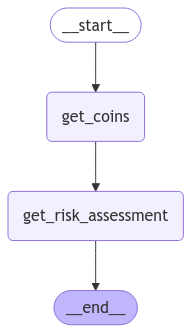

In [72]:
# search_tool = TavilySearchResults(max_results=2)

# class Agent:

#     def __init__(self, model):
#         graph_builder = StateGraph(State)
#         self.llm = model

#         # set_llm_cache(SQLiteCache(database_path=".langchain.db"))
#         # memory = SqliteSaver.from_conn_string(":memory:")
#         memory = MemorySaver()

#         graph_builder.add_node("get_coins", self.get_coins_node)
#         graph_builder.add_node("get_risk_assessment", self.get_risk_assessment_node)

#         graph_builder.add_edge(START, "get_coins")
#         graph_builder.add_edge("get_coins", "get_risk_assessment")
#         graph_builder.add_edge("get_risk_assessment", END)
        
#         self.graph = graph_builder.compile(checkpointer=memory)

    
#     def get_coins_node(self, state: State):
#         dexscreener_coins = get_top_dexscreener_coins()
#         prompt = f"""
#         {coins_prompt}
        
#         Task: {state['task']}
        
#         Data: {dexscreener_coins}
#         """

#         response = self.llm.with_structured_output(TokenSchemas).invoke(prompt)

#         return {"coins_to_invest": response}
    
#     def get_risk_assessment_node(self, state: State):
#         # First get the coins to analyze
#         coins = state['coins_to_invest']
        
#         # For each coin, search for news and information
#         for coin in coins.coins:
#             search_query = f"Token: {coin.name}; Chain: {coin.chain}; cryptocurrency news"
#             search_results = search_tool.invoke(search_query, search_depth="advanced")

#             # Extract relevant news from search results
#             news_items = []
#             for result in search_results:
#                 news_items.append(result['content'])

#             # Update the coin with news
#             coin.news = news_items

#         prompt = f"""
#         {risk_assessment_prompt}
        
#         Tokens to analyze: {coins}
        
#         Search results and news for each token have been added to help with your analysis.
#         Please assess the risk factors based on this information.
#         """

#         response = self.llm.with_structured_output(TokenSchemas).invoke(prompt)

#         return {"coins_risk_assessed": response}
        
    
#     def show_graph(self):
#         return Image(self.graph.get_graph().draw_mermaid_png())
    
#     def stream_graph_updates(self, config, user_input: str):
#         for event in self.graph.stream(
#             {"messages": [{"role": "user", "content": user_input}]},
#             config,
#             stream_mode="values",
#         ):
#             # for value in event.values():
#             event["messages"][-1].pretty_print()

#     def route_tools(self, state: State):
#         if isinstance(state, list):
#             ai_message = state[-1]
#         elif messages := state.get("messages", []):
#             ai_message = messages[-1]
#         else:
#             raise ValueError("No AI messages found in input state: {state}")

#         if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
#             return "tools"
#         return END
    


# model = ChatOpenAI(model="gpt-4o-mini", temperature=0)
# agent = Agent(model)

# agent.show_graph()

In [41]:
thread = {"configurable": {"thread_id": "1"}}

# events = agent.graph.stream(
#     {"task": "get me coins to BUY"},
#     thread,
#     stream_mode="values",
# )

# for event in events:
#     if "messages" in event:
#         event["messages"][-1].pretty_print()

for s in agent.graph.stream({
    'task': "suggest me coins to BUY",
}, thread):
    (print(s))

Response Coins to Invest: 
{'get_coins': {'coins_to_invest': TokenSchemas(coins=[TokenSchema(name='Straight Tuah Jail', address='6uGrKeFiTccSi4JdTQnfu43bn4p5A8qnSqSbABampump', chain='solana', price=0.0001354, market_cap=135441.0, volume=9169411.32, liquidity=53169.0, news=[], rank=5, risk_analysis='Moderate risk due to high transaction volume and recent price fluctuations.'), TokenSchema(name='JailMurad', address='644MryX1MXBNjA8QEUNeQ5HSEVZZqGRzPdiLz4EBpump', chain='solana', price=0.0001806, market_cap=180601.0, volume=28919434.81, liquidity=68330.85, news=[], rank=6, risk_analysis='Moderate risk with potential for growth based on increasing volume.'), TokenSchema(name='Bangui CentralAfricanRepublic', address='hLHvajeWaZhYwnhgDi3pSAdtYuaHVLUpZeDTDYWpump', chain='solana', price=0.006604, market_cap=6604305.0, volume=15460849.84, liquidity=354582.23, news=[], rank=7, risk_analysis='Higher risk due to volatility but significant liquidity and volume suggest potential for short-term gains.